# Research links

1) ZFNet: https://medium.com/coinmonks/paper-review-of-zfnet-the-winner-of-ilsvlc-2013-image-classification-d1a5a0c45103
2) Reverse Autoencoder: https://openaccess.thecvf.com/content_WACV_2020/papers/Lydia_Reverse_Variational_Autoencoder_for_Visual_Attribute_Manipulation_and_Anomaly_Detection_WACV_2020_paper.pdf
   1) I wanted to find some kind of reverse loss function calculations
3) a


In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch, gc

c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
IMAGE_SIZE = [28, 28]

TRAIN_BATCH_SIZE = 256
TRAIN_EPOCHS = 2

# Flush GPU memory, and garbadge collector

My GPU is always full, idk why but the jupyter kernel doesn't release the memory. So each run I flush the memory.

In [3]:
gc.collect()
torch.cuda.empty_cache()

# Load datasets

In [4]:
train_data_transformed = torchvision.datasets.MNIST(root="/MNIST", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=TRAIN_BATCH_SIZE)
img, _ = next(iter(train_dataloader))

# Check GPU

In [5]:
if torch.cuda.is_available():
	device = torch.device('cuda:0')
	print("Using GPU")
else:
	device = torch.device('cpu')
	print("Using CPU")

Using GPU


# TODO: Remove

ולגביי השאלה שלך איך לתת מוטיבציה. אז תשמור את הפלט מהשכבה החבויה של המקודד, ואת הפלט מהשכבה החבויה של המפרש,
תחשב את השגיאה ביניהם כמו שאתה מחשב את השגיאה של הקלט של המודל עם הפלט של המודל.


תסכום את שתי השגיאות, ואז תעשה 

backward.

ככה המודל גם יתאמץ להגיע לשגיאה נמוכה בשכבות החבויות.

# Activations for encoder and decoder reasons

We use sigmoid activation for the decoder, which outputs the final image (neurons), because it normalizes the neurons to be between 0 and 1.

We use ReLU activation for the encoder, in order to give the model 'more freedom' to change the values, and use real numbers instead of natural numbers for finer control over the weights.

# Autoencoder diagram for loss function

<![autoencoder diagram and its loss function calculation](./imgs/diagram.png)>

In [6]:
# Two latent dimensions = two latent layers
BOTTLENECK_DIM_1 = 392
BOTTLENECK_DIM_2 = 98

class Encoder(nn.Module):
	def __init__(self):
		super().__init__()

		self.linear1 = nn.Linear(IMAGE_SIZE[0] * IMAGE_SIZE[1], BOTTLENECK_DIM_1)
		self.linear2 = nn.Linear(BOTTLENECK_DIM_1, BOTTLENECK_DIM_2)
		self.relu = nn.ReLU()

	def forward(self, image: torch.Tensor) -> torch.Tensor:
		lin1 = self.linear1(image.flatten(start_dim=1))
		lin2 = self.linear2(lin1)
		res = self.relu(lin2)
		return res

class Decoder(nn.Module):
	def __init__(self):
		super().__init__()
		
		self.linear1 = nn.Linear(BOTTLENECK_DIM_2, BOTTLENECK_DIM_1)
		self.linear2 = nn.Linear(BOTTLENECK_DIM_1, IMAGE_SIZE[0] * IMAGE_SIZE[1])
		self.sigmoid = nn.Sigmoid()
	
	def forward(self, encoder_output: torch.Tensor) -> torch.Tensor:
		res = self.linear1(encoder_output)
		res = self.linear2(res)
		res = self.sigmoid(res)
		res = res.reshape(-1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])
		return res

# What does autoencoder mean for this assignment

It means that we compress the image to lower dimension, and then try best to reconstruct it back to higher dimension.

This 'streching' allows for data compression, because nearest neighbours of the source pixels is simillar as a group, less sharp, which allows for greater compression. Instead of using complicated mathenatics to accuracly compress the image, we can sue this instead.

What the professor tries to achieve, I think, it a method to compress and then decompress the image.

In [7]:
encoder = Encoder()
decoder = Decoder()

autoencoder = nn.Sequential(encoder,decoder).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters())
loss_func = nn.MSELoss()

# Train the model

In [8]:
def iterate_batch(imgs):
	imgs = imgs.to(device)
	optimizer.zero_grad()
	reconstructed=autoencoder(imgs)
	loss=loss_func(reconstructed,imgs)
	loss.backward()
	optimizer.step()
	return loss

In [9]:
batches=len(train_dataloader)

batch_loss=torch.empty(batches,device=device)
epoch_loss=torch.empty(TRAIN_EPOCHS,device=device)
for epoch_idx in tqdm(range(TRAIN_EPOCHS)):
	for batch_idx, (imgs, _) in enumerate(train_dataloader):
		batch_loss[batch_idx] = iterate_batch(imgs)
	with torch.no_grad():
		epoch_loss[epoch_idx]=batch_loss.mean()

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([256, 1, 28, 28])) that is different to the input size (torch.Size([128, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/2 [00:03<?, ?it/s]


RuntimeError: The size of tensor a (128) must match the size of tensor b (256) at non-singleton dimension 0

# Plot loss

We want to see loss approaching zero.

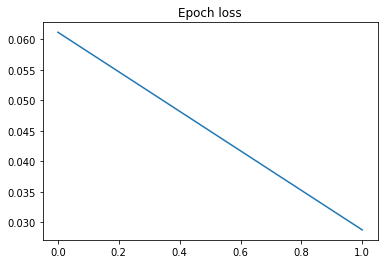

In [ ]:
plt.title("Epoch loss")
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

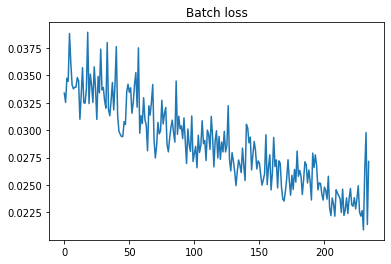

In [ ]:
plt.title("Batch loss")
plt.plot(batch_loss.cpu().detach());

# Show some images before and after autoencoder

In [ ]:
imgs, _ = next(iter(train_dataloader))

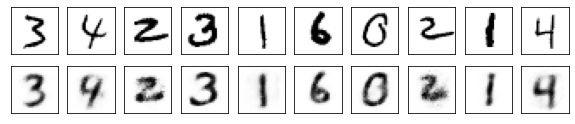

In [ ]:
num_images=10
with torch.no_grad():
	reconstructed=autoencoder(imgs.to(device)).cpu()
	fig,axes = plt.subplots(2,num_images,sharey=True)
	fig.set_figheight(2)
	fig.set_figwidth(10)
	rand_idx=torch.randint(size=(num_images,),high=imgs.size(0))
	for idx in range(num_images):
		axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(),cmap='Greys')
		axes[0,idx].axes.get_xaxis().set_visible(False)
		axes[0,idx].axes.get_yaxis().set_visible(False)

		axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(),cmap='Greys')
		axes[1,idx].axes.get_xaxis().set_visible(False)
		axes[1,idx].axes.get_yaxis().set_visible(False)


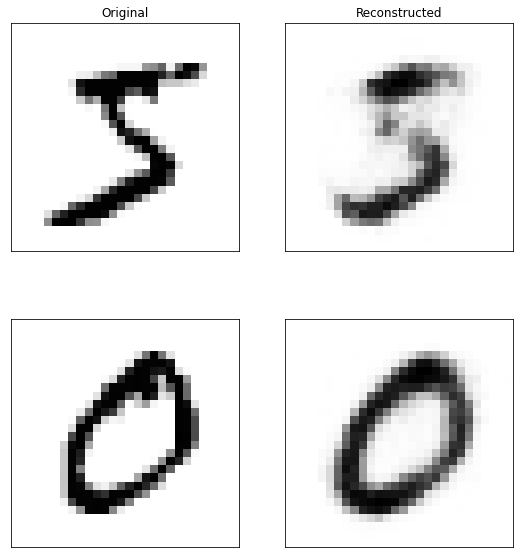

In [ ]:
num_images=2
with torch.no_grad():
	reconstructed=autoencoder(imgs.to(device)).cpu()
	fig,axes = plt.subplots(num_images,2)
	fig.set_figheight(10)
	fig.set_figwidth(9)
	for idx in range(num_images):
		axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(),cmap='Greys')
		axes[idx,0].axes.get_xaxis().set_visible(False)
		axes[idx,0].axes.get_yaxis().set_visible(False)
    
		axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(),cmap='Greys')
		axes[idx,1].axes.get_xaxis().set_visible(False)
		axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");